<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/Scaled_LSTM_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P1: Data mediata

this tutorial from : https://www.youtube.com/watch?v=tepxdcepTbY&ab_channel=DigitalSreeni

# P2: Import libraries

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ML')

In [ ]:
# read data
df=pd.read_csv('input_data/GE.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-06,6.98,7.08,6.89,7.00,6.971575,75429400
1,2020-07-07,6.89,6.89,6.75,6.76,6.732550,62433700
2,2020-07-08,6.82,6.87,6.72,6.86,6.832144,64439300
3,2020-07-09,6.83,6.83,6.58,6.58,6.553280,74748000
4,2020-07-10,6.54,6.72,6.53,6.69,6.662834,63423400


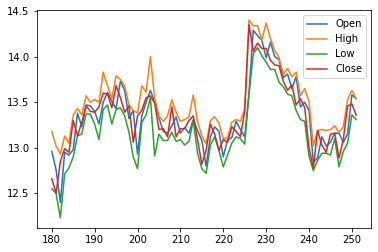

In [ ]:
# Separate dates for future ploting
train_dates=pd.to_datetime(df['Date'])
# Variables for trainning 
cols=df.columns.to_list()[1:5]
df_for_training=df[cols].astype(float)
# plot check last 36
df_for_training.iloc[-72:,:].plot.line()



# P3: Scaled data training

* LSTMS uses sigmoid and tanh are sensitive to magnitude. Values need to be normalized


In [ ]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

# P4: Reshape data training to tensorflow form
* n_samples x timesteps x n_features
* ex here: n_featrure =2, timesteps=3, n_samples=5 (input data has 9 rows)


In [ ]:
trainX=[]
trainY=[]
n_future=1 # Number of days we want to predict into the future
n_past=14 # Number of past days we want to use to predict
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,0])
trainX=np.array(trainX)
trainY=np.array(trainY)
print(trainX.shape, trainY.shape)

(238, 14, 4) (238, 1)


# P5: Check data input
* value at index 14 of train = value at 0 of Y
* value at index 15 of train = value at 1 of Y
* look 14 values to predict values at 15

In [ ]:
df_for_training_scaled[14,0]

-1.1346187566339976

In [ ]:
trainX[14,0]

array([-1.13461876, -1.15237258, -1.15958434, -1.18953786])

In [ ]:
trainY[1]

array([-1.1972009])

# P6: Define model

In [ ]:
model=Sequential()
model.add(LSTM(64,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


# P7: Fit model

In [ ]:
history=model.fit(trainX, trainY,epochs=10,batch_size=16,validation_split=0.1,verbose=1)

Epoch 1/10
14/14 [==============================] - 25s 102ms/step - loss: 0.5994 - val_loss: 0.1174
Epoch 2/10
14/14 [==============================] - 0s 14ms/step - loss: 0.0827 - val_loss: 0.0377
Epoch 3/10
14/14 [==============================] - 0s 14ms/step - loss: 0.0624 - val_loss: 0.0489
Epoch 4/10
14/14 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0285
Epoch 5/10
14/14 [==============================] - 0s 15ms/step - loss: 0.0493 - val_loss: 0.0253
Epoch 6/10
14/14 [==============================] - 0s 15ms/step - loss: 0.0445 - val_loss: 0.0246
Epoch 7/10
14/14 [==============================] - 0s 13ms/step - loss: 0.0523 - val_loss: 0.0238
Epoch 8/10
14/14 [==============================] - 0s 13ms/step - loss: 0.0441 - val_loss: 0.0251
Epoch 9/10
14/14 [==============================] - 0s 13ms/step - loss: 0.0599 - val_loss: 0.0228
Epoch 10/10
14/14 [==============================] - 0s 14ms/step - loss: 0.0486 - val_loss: 0.0283


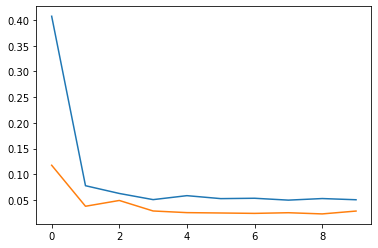

In [ ]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')

# P8: Forecasting
* Start with the last day in training date and predict future

In [ ]:
n_future=90 # Redefing n_future to extend prediction dates beyond original n_futuredates
forecast_period_dates=pd.date_range(list(train_dates)[-1],periods=n_future,freq='1d')

forecast=model.predict(trainX[-n_future:])

# P9: Invert tranfrom scaled
* Perform inverse transfromation to rescale back to original range
* Since we used 5 variable for transform, the inverse expects same dimensions
* We copy our values 5 times and discard them after inverse transform

In [ ]:
forecast_copies=np.repeat(forecast,df_for_training.shape[1],axis=-1)
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]

In [ ]:
# Covert timestamp to date
forecast_dates=[]
for i in range(len(forecast_period_dates)):
    forecast_dates.append(forecast_period_dates[i])

# P10: Compare results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


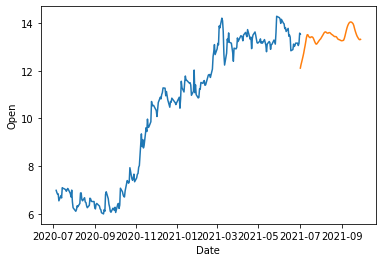

In [ ]:
df_forecast=pd.DataFrame({'Date':np.array(forecast_dates),'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

original=df[['Date','Open']]
original['Date']=pd.to_datetime(original['Date'])
original=original.loc[original['Date']>='2020-5-1']
sns.lineplot(original['Date'],original['Open'])
sns.lineplot(df_forecast['Date'],df_forecast['Open'])